# Lab 3 - Network Intrusion Detection
- Daniel Vance
- Peter Thung
- Ravi Srinivas
- Randy Balzer

## Business Understanding

Daniel

*Describe the purpose of the data set you selected. How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific data set and the stakeholders' needs?*

## Data Understanding

Daniel

- *Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*
- *Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

In [1]:
# Setup
# Imports
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt
from sklearn.svm import SVC

from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import RandomizedPCA 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

import seaborn as sns
import pandas as pd
import numpy as np


%matplotlib inline

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
# Load UNSW_NB15 into a Pandas dataframe
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')

# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print "[" + feature + "]" + "still found, check removal code. (Should not see this)"      

df_five = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'label' ]] 

df_five.info()
df_five.describe()

duplicate record deleted successfully: 82328 observations remaining
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 6 columns):
sttl                82328 non-null int64
ct_dst_sport_ltm    82328 non-null int64
ct_src_dport_ltm    82328 non-null int64
swin                82328 non-null int64
dwin                82328 non-null int64
label               82328 non-null int64
dtypes: int64(6)
memory usage: 4.4 MB


,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,swin,dwin,label
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000
mean,180.973448,3.663092,4.929040,133.453175,128.280464,0.550578
std,101.512436,5.915518,8.389724,127.357276,127.491408,0.497438
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,62.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,254.000000,1.000000,1.000000,255.000000,255.000000,1.000000
75%,254.000000,3.000000,4.000000,255.000000,255.000000,1.000000
max,255.000000,38.000000,59.000000,255.000000,255.000000,1.000000


## Data Preparation:¶
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [9]:
# One-hot encode our object features:

# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print "Value error({0}): ".format(e)  # Note
df.info()

Value error(No objects to concatenate): 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB


In [13]:
# Go ahead and drop both 'label' 
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to predict!
dfcopy.info() # should have 190 entries
    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 190 entries, dur to state_RST
dtypes: float64(162), int64(28)
memory usage: 120.0 MB


In [21]:
pd.set_option('display.max_columns', 500)
dfcopy.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.00000,8.232800e+04,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,8.232800e+04,8.232800e+04,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.00000

## Modeling and Evaluation

#### Train and Adjust Parameters

In [ ]:
"""
    Models:
        K-Means - PETER
        MiniBatch - RANDY
        DBSCAN - RAVI
        GMM - DANIEL
"""

4
Estimated number of clusters: 4


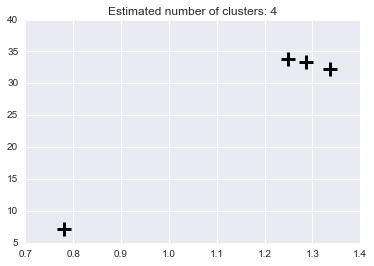

In [33]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

n_clusters = 4
data = X
model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
#model = DBSCAN(eps=0.15, min_samples=10).fit(data)

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print( len(set(labels)))
print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(data, labels))

# Getting memory error with silhouette
#silhouette_per_sample = metrics.silhouette_samples(data,labels)

# get the middle of each cluster
centroids = []
for lab in range(0,n_clusters_):

    centroids.append( [np.mean(data[np.where(labels==lab),0]), np.mean(data[np.where(labels==lab),1])] )
centroids = np.array(centroids)

plt.figure()
#plt.scatter(data[:, 0], data[:, 1], c=labels,           
#                    cmap=plt.cm.spectral, s=5, linewidths=0)

if len(centroids)>0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.figure()
#plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
#                cmap=plt.cm.gray, s=5, linewidths=0)
#plt.title('Clusters with silhouette coefficient coloring')
plt.show()

#### Evaluate and Compare

#### Visualize Results

In [ ]:
"""
    Can we visualize a data set with this many features?
    Can we visualize on the attack categories?
"""

#### Summarize the Ramifications

## Deployment

Resuse from Lab 2

- *Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*
- *How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?*
- *How would your deploy your model for interested parties?*
- *What other data should be collected?*
- *How often would the model need to be updated, etc.?*

## Exceptional Work